# Abstract

This notebook was created for OHW23's Sea Surface Temprature (SST) Prediction project, as part of the suite of deep learning models used. We will be creating a simple 3D-CCN model on historic SST data and comparing model outputs to known SST measurements to evaluate the model's accuracy

# Setup virtual environment and import modules

IF you don't have root access for your machine/environment (if you run into something like `ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/env/lib/python3.10/site-packages/bin'` when running `pip install` AND you don't have all of the modules contained two cells down (you run into `ImportError`), uncomment and run next cell once. Otherwise, you can just `pip install` missing modules. If you have everything, nothing needs to be done :)

Explanation:
- First line `%%sh` converts the cell into bash commands
- Second line creates virtual environment. Named `myenv` here
- Third line links existing modules to your newly created environment
- Fourth line activates virtual environment
- Fifth line runs `pip install` for any missing modules. Just `tensorflow` and `tensorboard` in my case
- Sixth line converts virtual environment into a Jupyter kernel

Once the next cell finishes running, restart your server - your newly created kernel wil be available to select in the top right corner

In [ ]:
# !pip install tensorflow==2.8
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [1]:
# %%sh
# python -m venv ~/venvs/myenv
# realpath /env/lib/python3.10/site-packages > ~/venvs/myenv/lib/python3.10/site-packages/base_venv.pth
# source ~/venvs/myenv/bin/activate
# pip install tensorflow tensorboard
# python -m ipykernel install --user --name=myenv --display-name "myenv"

In [2]:
import gc
import warnings

import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array as da
import tensorflow as tf
import tensorboard

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv3D, Flatten, Dense, MaxPool3D, GlobalAveragePooling3D, Dropout, MaxPooling3D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.variables import Variable

from dask.distributed import Client, LocalCluster
from dask.delayed import delayed
from sklearn.model_selection import train_test_split

2023-08-11 09:37:51.116734: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 09:37:52.157884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 09:37:55.362040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


I tend to ignore warnings like a main character in a horror movie but they can be helpful

In [3]:
warnings.simplefilter('ignore')

# Initialise Dask LocalCluster

In [4]:
cluster = LocalCluster(n_workers=16)
client = Client(cluster)

In [5]:
# Hao's dashboard link if in CSIRO EASI environment:
# https://hub.csiro.easi-eo.solutions/user/csiro-csiro-aad_tan196@csiro.au/proxy/8787/status
# Otherwise use provided dashboard link

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 230.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36395,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 230.00 GiB
Comm: tcp://127.0.0.1:43297,Total threads: 2
Dashboard: http://127.0.0.1:33523/status,Memory: 14.38 GiB
Nanny: tcp://127.0.0.1:33929,


# Load MUR Satellite Data

Read data straight from public S3 bucket: https://registry.opendata.aws/mur/

In [6]:
# Bypass AWS tokens, keys etc.
s3 = s3fs.S3FileSystem(anon=True)

# Verify that we're in the right place
sst_files = s3.ls("mur-sst/zarr-v1/")
sst_files

['mur-sst/zarr-v1/',
 'mur-sst/zarr-v1/.zattrs',
 'mur-sst/zarr-v1/.zgroup',
 'mur-sst/zarr-v1/.zmetadata',
 'mur-sst/zarr-v1/analysed_sst',
 'mur-sst/zarr-v1/analysis_error',
 'mur-sst/zarr-v1/lat',
 'mur-sst/zarr-v1/lon',
 'mur-sst/zarr-v1/mask',
 'mur-sst/zarr-v1/sea_ice_fraction',
 'mur-sst/zarr-v1/time']

In [7]:
%%time

# Load
ds = xr.open_zarr(
        store=s3fs.S3Map(
            root=f"s3://{sst_files[0]}", s3=s3, check=False
        )
     )

CPU times: user 2.9 s, sys: 314 ms, total: 3.21 s
Wall time: 23.6 s


In [8]:
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

# Mask sea ice and land

We only want water to be part of our dataset

In [9]:
sst = ds['analysed_sst']
cond = (ds.mask==1) & ((ds.sea_ice_fraction<.15) | np.isnan(ds.sea_ice_fraction))

analysed_sst = ds['analysed_sst'].where(cond)
analysed_sst

<xarray.DataArray 'analysed_sst' (time: 6443, lat: 17999, lon: 36000)>
dask.array<where, shape=(6443, 17999, 36000), dtype=float32, chunksize=(5, 1799, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [10]:
# I only remembered to apply masks when the predicted SST plots appeared
# Since this notebook was written on the basis of our data being a xr.DataSet, convert xr.DataArray back into xr.Dataset
ds = analysed_sst.to_dataset()

# Subsetting dataset so JupyterHub can handle it

In [11]:
# Check that data is daily only and no missing days
assert pd.infer_freq(ds.time.values) == 'D'

Good job NASA :)

In [12]:
def dates_to_mur_indices(start, end):
    
    start_of_dataset = np.datetime64('2002-06-01')
    end_of_dataset = np.datetime64('2020-01-20')
    
    if (type(start) == str) and (type(end) == str):
        try:
            start = np.datetime64(start)
            end = np.datetime64(end)
        except ValueError as e:
            print(e)
            raise TypeError(f'Date(s) not in the format YYYY-MM-DD')
    else:
        raise TypeError(f'Please enter dates as np.datetime64 or strings in the format YYYY-MM-DD')
        
    assert (start >= start_of_dataset) and (start < end_of_dataset), f'{start} out of dataset range {start_of_dataset} - {end_of_dataset}'
    assert (end <= end_of_dataset) and (end > start_of_dataset), f'{end} out of dataset range {start_of_dataset} - {end_of_dataset}'
    assert start <= end, f'start date {start} after end date {end}'
    
    start_index = (start - start_of_dataset).astype(int)
    end_index = (end - start_of_dataset).astype(int) + 1
    
    return range(start_index, end_index)

In [13]:
# Taking 3 months' worth of data
ds_sample = ds.isel(time=dates_to_mur_indices('2018-01-01', '2019-01-01'))
# ds_sample = ds.isel(time=0)

In [14]:
ds_sample

<xarray.Dataset>
Dimensions:       (lat: 17999, lon: 36000, time: 366)
Coordinates:
  * lat           (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon           (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time          (time) datetime64[ns] 2018-01-01T09:00:00 ... 2019-01-01T09...
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(2, 1799, 3600), meta=np.ndarray>

In [15]:
# Focus on our area of interest
ds_sample = ds_sample.sel(lat=slice(-5, 35), lon=slice(45,90))

In [16]:
# Downsample by factor of 10 - if your environment can't handle volume of data
ds_sample = ds_sample.isel(lat=slice(0, None, 10), lon=slice(0, None, 10))

Here I was thinking that NaNs would interfere with our model outputs and not allow it to run efficiently or at all. Turns out later that this wasn't the case - can skip. Thanks Jiarui and team for code snippet

In [17]:
# # Get dates with NaN values
# all_nan_dates = np.isnan(ds_sample["analysed_sst"]).any(dim=["lon", "lat"]).compute()

# # Were there any?
# if not all_nan_dates.any():
#     print('No NaN values')
# else:
#     print('NaN values exist')

In [18]:
# # How many?
# np.isnan(ds_sample["analysed_sst"]).sum(dim=["lon", "lat"]).compute()

In [19]:
# # Fill dataset with -32768
# # May be better to remove
# ds_sample['analysed_sst'] = ds_sample['analysed_sst'].fillna(-32768)

In [20]:
# Rename SST variable so that I don't need to make changes to Jiarui and team's functions below
ds_sample = ds_sample.rename({'analysed_sst': 'sst'})

In [21]:
ds_sample

<xarray.Dataset>
Dimensions:  (lat: 401, lon: 451, time: 366)
Coordinates:
  * lat      (lat) float32 -5.0 -4.9 -4.8 -4.7 -4.6 ... 34.6 34.7 34.8 34.9 35.0
  * lon      (lon) float32 45.0 45.1 45.2 45.3 45.4 ... 89.6 89.7 89.8 89.9 90.0
  * time     (time) datetime64[ns] 2018-01-01T09:00:00 ... 2019-01-01T09:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(2, 50, 271), meta=np.ndarray>

# Preprocess and split data (thanks for the functions Jiarui and team)

In [22]:
def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

#TODO: Utilise multiprocessing to parallelise if possible?
def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)


def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y


def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [23]:
%%time

processed_data = preprocess_data(ds_sample)
processed_data

CPU times: user 16.6 s, sys: 426 ms, total: 17 s
Wall time: 34.3 s


dask.array<concatenate, shape=(366, 401, 451), dtype=float32, chunksize=(5, 180, 271), chunktype=numpy.ndarray>

In [24]:
# Split data into training and test
X, y = prepare_data_from_processed(processed_data)
X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

In [25]:
training_dims = np.shape(X_train)
training_dims

(252, 5, 401, 451)

# Build model

In [26]:
def create_simple_model(input_shape, target_shape):
    model = Sequential()
    
    model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(target_shape[0] * target_shape[1], activation='linear'))  # Output flattened to match target shape
    model.add(Reshape(target_shape))  # Reshape output to match target shape

    return model

# Define input shape and target shape and create the model
input_shape = X_train.shape[1:] + (1,)
target_shape = y_train.shape[1:]
model = create_simple_model(input_shape, target_shape)
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 5, 401, 451, 8)    224       
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 200, 225, 8)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 200, 225, 16)   3472      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 100, 112, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 100, 112, 32)   13856     
                                                                 
 flatten (Flatten)           (None, 358400)            0

# Evalute model

In [27]:
%%time

# TODO: Try other optimizers (ensemble of Adagrad and others)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

val_dataset = val_dataset.batch(32)

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stop])

2023-08-11 09:40:31,113 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-11 09:40:34,410 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-11 09:40:34,910 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-11 09:40:35,486 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-11 09:40:36,160 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-11 09:40:36,960 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-08-11 09:40:39,332 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-08-11 09:41:10,972 - distributed.utils_perf - WARNING - full garbage collections took

Epoch 1/20
8/8 [==============================] - 4s 311ms/step - loss: 0.6420 - mse: 0.6420 - val_loss: 0.2504 - val_mse: 0.2504
Epoch 2/20
8/8 [==============================] - 2s 286ms/step - loss: 0.2450 - mse: 0.2450 - val_loss: 0.2332 - val_mse: 0.2332
Epoch 3/20
8/8 [==============================] - 2s 281ms/step - loss: 0.1914 - mse: 0.1914 - val_loss: 0.2210 - val_mse: 0.2210
Epoch 4/20
8/8 [==============================] - 2s 284ms/step - loss: 0.1587 - mse: 0.1587 - val_loss: 0.2111 - val_mse: 0.2111
Epoch 5/20
8/8 [==============================] - 2s 278ms/step - loss: 0.1375 - mse: 0.1375 - val_loss: 0.2120 - val_mse: 0.2120
Epoch 6/20
8/8 [==============================] - 2s 282ms/step - loss: 0.1256 - mse: 0.1256 - val_loss: 0.2065 - val_mse: 0.2065
Epoch 7/20
8/8 [==============================] - 2s 281ms/step - loss: 0.1178 - mse: 0.1178 - val_loss: 0.2035 - val_mse: 0.2035
Epoch 8/20
8/8 [==============================] - 2s 285ms/step - loss: 0.1114 - mse: 0.11

In [28]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    # land_mask = np.load('land_mask.npy')
    
    # Set those positions in the prediction to NaN
    # Due to resolution mismatch between ERA5 and MUR data, this land_mask cannot be used. Ignore for now
    # prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values.astype('datetime64[D]') == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values
    print(input_data_raw.shape)
    print(true_output_raw.shape)
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    print(prediction_postprocessed.shape)
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ..., np.newaxis]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title=''):
            sample_2d = np.squeeze(sample)
            plt.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.title(title)
            plt.colorbar()
            
            # I am getting a plot mirrored along the y-axis
            # Should probably should invert actual data rather than plot
            
            plt.gca().invert_yaxis()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data_raw, prediction_postprocessed, true_output_raw

In [29]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

2023-08-11 09:44:00,911 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-08-11 09:44:01,526 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-08-11 09:44:02,282 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-08-11 09:44:03,126 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-08-11 09:44:04,383 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-08-11 09:44:10,165 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-08-11 09:44:10,905 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-08-11 09:44:11,773 - distributed.utils_perf - WARNING - full garbage collections took

(5, 401, 451)
(401, 451)
1/1 [==============================] - 0s 93ms/step
(401, 451)


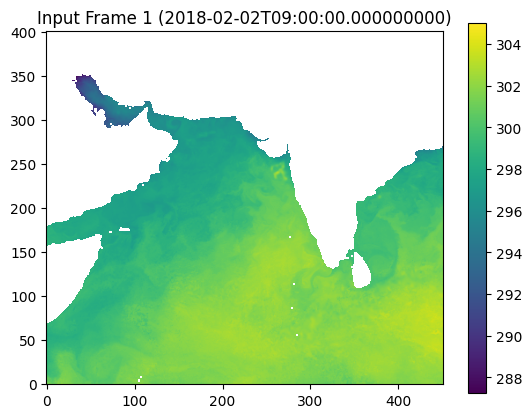

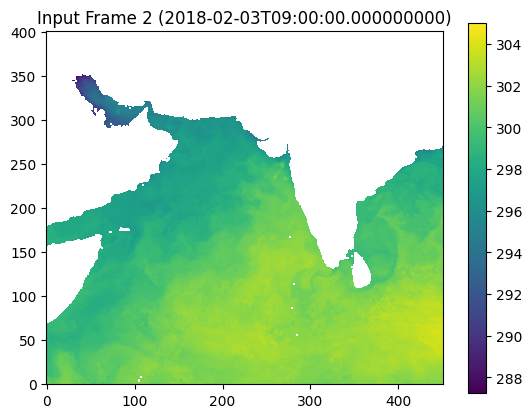

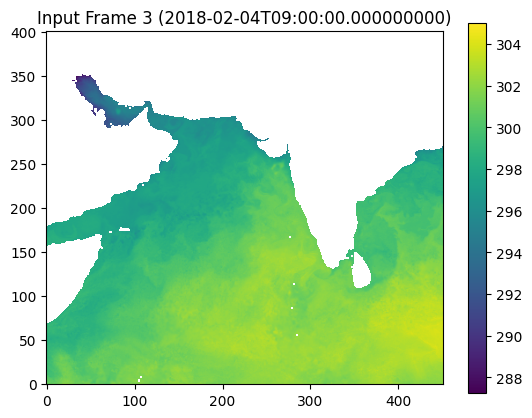

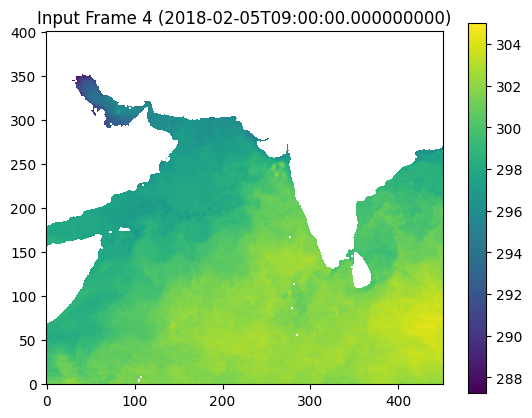

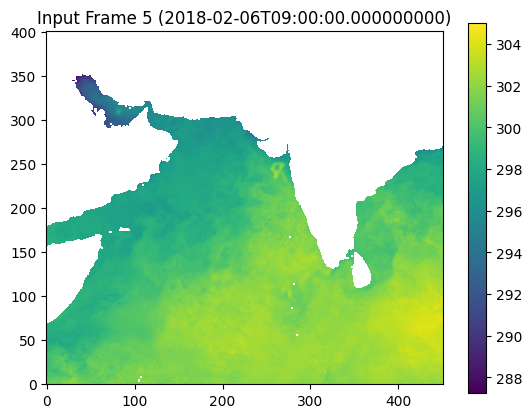

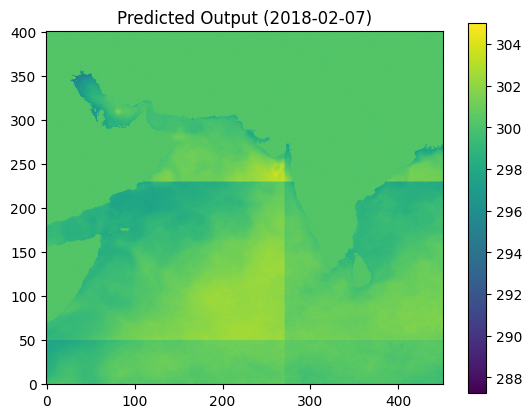

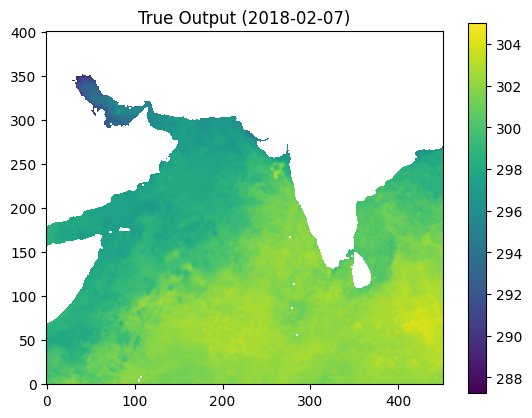

MAE between Predicted Output and True Output: 1.3159540891647339
MAE between Last Input Frame and True Output: 0.2536998689174652


In [31]:
date_to_predict = '2018-02-07'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, ds_sample)

predicted_mae = compute_mae(true_output, predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mae = compute_mae(true_output_2d, last_input_frame_2d)
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")